In [3]:
import tensorflow as tf
import pandas as pd 
import re
import collections
import os
import numpy as np
import math
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from six.moves import xrange
from tempfile import gettempdir

In [4]:
movies = pd.read_csv("wiki_movie_plots.csv")

Step one: Convert plot to vectorized sequence of words.

Step two: Set up LSTM to generate predictions.

Step three: Interpret predictions.

Ideas:
- Predictions at every word (or sentence, or paragraph), see where they change

In [5]:
movies.head()

Release Year                             Title Origin/Ethnicity  \
0          1901            Kansas Saloon Smashers         American   
1          1901     Love by the Light of the Moon         American   
2          1901           The Martyred Presidents         American   
3          1901  Terrible Teddy, the Grizzly King         American   
4          1902            Jack and the Beanstalk         American   

                             Director Cast    Genre  \
0                             Unknown  NaN  unknown   
1                             Unknown  NaN  unknown   
2                             Unknown  NaN  unknown   
3                             Unknown  NaN  unknown   
4  George S. Fleming, Edwin S. Porter  NaN  unknown   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://en.wikipedia.org/wiki/Terrible_Teddy,_...   
4  https://en.wikipedia.org/wiki/Jack_and_the_Bea...   

                                                Plot  
0  A bartender is working at a saloon, serving dr...  
1  The moon, painted with a smiling face hangs ov...  
2  The film, just over a minute long, is composed...  
3  Lasting just 61 seconds and consisting of two ...  
4  The earliest known adaptation of the classic f...

In [6]:
genres_to_consider = ["drama", "comedy", "horror", "action", "thriller", "romance", "western"]
movies = movies[movies['Genre'].isin(genres_to_consider)]

In [7]:
movies.groupby('Genre').count().sort_values("Title", ascending=False)

Release Year  Title  Origin/Ethnicity  Director  Cast  Wiki Page  \
Genre                                                                        
drama             5964   5964              5964      5964  5841       5964   
comedy            4379   4379              4379      4379  4347       4379   
horror            1167   1167              1167      1167  1124       1167   
action            1098   1098              1098      1098  1087       1098   
thriller           966    966               966       966   955        966   
romance            923    923               923       923   918        923   
western            865    865               865       865   864        865   

          Plot  
Genre           
drama     5964  
comedy    4379  
horror    1167  
action    1098  
thriller   966  
romance    923  
western    865

In [8]:
movies.head()

Release Year                            Title Origin/Ethnicity  \
6           1903          The Great Train Robbery         American   
7           1904                  The Suburbanite         American   
14          1907  How Brown Saw the Baseball Game         American   
15          1907                     Laughing Gas         American   
16          1908         The Adventures of Dollie         American   

                Director                               Cast    Genre  \
6        Edwin S. Porter                                NaN  western   
7     Wallace McCutcheon                                NaN   comedy   
14               Unknown                            Unknown   comedy   
15  Edwin Stanton Porter    Bertha Regustus, Edward Boulden   comedy   
16        D. W. Griffith  Arthur V. Johnson, Linda Arvidson    drama   

                                            Wiki Page  \
6   https://en.wikipedia.org/wiki/The_Great_Train_...   
7       https://en.wikipedia.org/wiki/The_Suburbanite   
14  https://en.wikipedia.org/wiki/How_Brown_Saw_th...   
15  https://en.wikipedia.org/wiki/Laughing_Gas_(fi...   
16  https://en.wikipedia.org/wiki/The_Adventures_o...   

                                                 Plot  
6   The film opens with two bandits breaking into ...  
7   The film is about a family who move to the sub...  
14  Before heading out to a baseball game at a nea...  
15  The plot is that of a black woman going to the...  
16  On a beautiful summer day a father and mother ...

In [9]:
movies = movies.sample(frac=1) # Shuffles the data 

In [10]:
N_train = 600
N_test = 200

train = None
test = None

train = movies[movies['Genre'] == 'drama'][:N_train]
test = movies[movies['Genre'] == 'drama'][N_train:]

for genre in genres_to_consider[1:]:
    tr = movies[movies['Genre'] == genre][:N_train]
    te = movies[movies['Genre'] == genre][N_train:]
    train = pd.concat([train, tr])
    test = pd.concat([test, te])
    

In [11]:
train.head()

Release Year                            Title Origin/Ethnicity  \
5460           1951  Pandora and the Flying Dutchman         American   
13067          1997                 Miss Evers' Boys         American   
32861          1960             Cruel Story of Youth         Japanese   
4899           1949               The Glass Mountain         American   
9712           1980                 Honeysuckle Rose         American   

                          Director  \
5460                  Albert Lewin   
13067               Joseph Sargent   
32861  Oshima, NagisaNagisa Oshima   
4899                    Henry Cass   
9712              Jerry Schatzberg   

                                             Cast  Genre  \
5460                     Ava Gardner, James Mason  drama   
13067           Alfre Woodard, Laurence Fishburne  drama   
32861  Yusuke Kawazu, Miyuki Kuwano, Yoshiko Kuga  drama   
4899                 Michael Denison, Dulcie Gray  drama   
9712       Willie Nelson, Dyan Cannon, Amy Irving  drama   

                                               Wiki Page  \
5460   https://en.wikipedia.org/wiki/Pandora_and_the_...   
13067   https://en.wikipedia.org/wiki/Miss_Evers%27_Boys   
32861  https://en.wikipedia.org/wiki/Cruel_Story_of_Y...   
4899   https://en.wikipedia.org/wiki/The_Glass_Mounta...   
9712   https://en.wikipedia.org/wiki/Honeysuckle_Rose...   

                                                    Plot  
5460   In 1930, fishermen in the small Spanish port o...  
13067  The film tells the story of the Tuskegee exper...  
32861  After Makoto Shinjo hitchhikes a ride, the dri...  
4899   Struggling composer Richard Wilder (Michael De...  
9712   Buck Bonham is a country singer, with a good f...

### Word Embeddings Using Word2Vec on Wikipedia Corpus

In [12]:
d = {
    "(" : "( ",
    ")" : " )",
    "-" : " - ",
    "," : " ,",
    "\n" : "",
    "\r" : "",
    "\"" : " \" ",
    "'" : " ' ",
    "." : " . ",
    "ENDOFARTICLE": ""
}

### Function to replace various characters in a single pass over text

In [13]:
def multiple_replace(d, text):
    
    regex = re.compile("(%s)" % "|".join(map(re.escape, d.keys())))
    
    return regex.sub(lambda x: d[x.string[x.start():x.end()]], text) 

In [14]:
filename = "wiki"
words = []

files_in_directory = os.listdir(filename)
print("Files in directory: " + str(len(files_in_directory)))
print("Files being used: " + str(10))

for file in files_in_directory[:10]:
    f = open(filename + "/" + file, 'r', encoding = "ISO-8859-1")
    f = f.read()
    f = multiple_replace(d, f)
    f = re.sub("<doc.{20,150}>", "", f)
    f = re.sub("</doc>", "", f)
    all_words = f.split(" ")
    for word in all_words:
        words.append(word)


Files in directory: 164
Files being used: 10


In [15]:
def build_batch(words, n_words):
    word_count = [["UNK", -1]]
    word_count.extend(collections.Counter(words).most_common(n_words - 1))
    
    d = {}
    for w, _ in word_count:
        d[w] = len(d)
        
    data = []
    num_unks = 0
    for w in words:
        index = d.get(w, 0)
        if index == 0:
            num_unks += 1
        data.append(index)
            
    word_count[0][1] = num_unks
    
    reversed_dictionary = dict(zip(d.values(), d.keys()))
    
    return data, word_count, d, reversed_dictionary

In [16]:
n_words = 100000 # Subject to change 
data, word_count, vocab_dictionary, reversed_dictionary = build_batch(words, n_words)

In [17]:
word_index = len(words)

In [18]:
data_index = 0
def generate_batch(batch_size, data, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
            
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [19]:
# Model to train embeddings

In [20]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
num_sampled = 64

valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [21]:
graph = tf.Graph()

with graph.as_default():
    
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    with tf.name_scope('embeddings'):
        embeddings = tf.Variable(
            tf.random_uniform([n_words, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    with tf.name_scope("weights"):
        
        nce_weights = tf.Variable(tf.truncated_normal([n_words, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        
    with tf.name_scope('biases'):
        
        nce_biases = tf.Variable(tf.zeros([n_words]))
        
    with tf.name_scope('loss'):
      loss = tf.reduce_mean(
          tf.nn.nce_loss(
              weights=nce_weights,
              biases=nce_biases,
              labels=train_labels,
              inputs=embed,
              num_sampled=num_sampled,
              num_classes=n_words))
    
    tf.summary.scalar('loss', loss)
    
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                              valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)
    
    merged = tf.summary.merge_all()
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# Run model to obtain embeddings for each word 

In [22]:
n_steps = 100001 # Can increase 
log_dir = "182/LSTMsAndInterpretability"

with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter(log_dir, session.graph)
    
    init.run()
    print('Initialized')
    
    average_loss = 0
    for step in range(n_steps):
        batch_inputs, batch_labels = generate_batch(batch_size,
                                                  data,
                                                  num_skips,
                                                  skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        run_metadata = tf.RunMetadata()
    
        _, summary, loss_val = session.run([optimizer, merged, loss],
                                         feed_dict=feed_dict,
                                         run_metadata=run_metadata)
    
        average_loss += loss_val
    
        if step % 5000 == 0:
            if step > 0:
                average_loss /= 5000
            # The average loss is an estimate of the loss over the last 5000
            # batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
            
    final_embeddings = normalized_embeddings.eval()
        
    with open(log_dir + '/metadata.tsv', 'w') as f:
        for i in range(n_words):
            f.write(reversed_dictionary[i] + '\n')
        
    saver.save(session, os.path.join(log_dir, 'model.ckpt'))

Initialized
Average loss at step  0 :  320.6707763671875
Average loss at step  5000 :  108.59389023094177
Average loss at step  10000 :  49.42965269804001
Average loss at step  15000 :  28.29292200694084
Average loss at step  20000 :  19.953844412708282
Average loss at step  25000 :  14.789656452035905
Average loss at step  30000 :  15.67474107079506
Average loss at step  35000 :  9.723697624516488
Average loss at step  40000 :  8.540959377479552
Average loss at step  45000 :  7.683079879307747
Average loss at step  50000 :  7.064424713420868
Average loss at step  55000 :  6.573339777469635
Average loss at step  60000 :  8.061197406244277
Average loss at step  65000 :  5.948401457357407
Average loss at step  70000 :  5.716561012506485
Average loss at step  75000 :  5.825897537589073
Average loss at step  80000 :  5.374435644412041
Average loss at step  85000 :  5.295071923828125
Average loss at step  90000 :  5.20729268116951
Average loss at step  95000 :  5.123191454613209
Average los

In [23]:
cowboy = final_embeddings[vocab_dictionary['cowboy']]
gun = final_embeddings[vocab_dictionary['gun']]
random_word = final_embeddings[vocab_dictionary['building']]
print(np.linalg.norm(cowboy - gun))
print(np.linalg.norm(cowboy - random_word))

1.2986456
1.1884176


In [24]:
# Save model embeddings so this part does not need to be run again 

In [25]:
# Set up LSTM

In [26]:
train.head()

Release Year                            Title Origin/Ethnicity  \
5460           1951  Pandora and the Flying Dutchman         American   
13067          1997                 Miss Evers' Boys         American   
32861          1960             Cruel Story of Youth         Japanese   
4899           1949               The Glass Mountain         American   
9712           1980                 Honeysuckle Rose         American   

                          Director  \
5460                  Albert Lewin   
13067               Joseph Sargent   
32861  Oshima, NagisaNagisa Oshima   
4899                    Henry Cass   
9712              Jerry Schatzberg   

                                             Cast  Genre  \
5460                     Ava Gardner, James Mason  drama   
13067           Alfre Woodard, Laurence Fishburne  drama   
32861  Yusuke Kawazu, Miyuki Kuwano, Yoshiko Kuga  drama   
4899                 Michael Denison, Dulcie Gray  drama   
9712       Willie Nelson, Dyan Cannon, Amy Irving  drama   

                                               Wiki Page  \
5460   https://en.wikipedia.org/wiki/Pandora_and_the_...   
13067   https://en.wikipedia.org/wiki/Miss_Evers%27_Boys   
32861  https://en.wikipedia.org/wiki/Cruel_Story_of_Y...   
4899   https://en.wikipedia.org/wiki/The_Glass_Mounta...   
9712   https://en.wikipedia.org/wiki/Honeysuckle_Rose...   

                                                    Plot  
5460   In 1930, fishermen in the small Spanish port o...  
13067  The film tells the story of the Tuskegee exper...  
32861  After Makoto Shinjo hitchhikes a ride, the dri...  
4899   Struggling composer Richard Wilder (Michael De...  
9712   Buck Bonham is a country singer, with a good f...

In [27]:
def encodeLabel(df, col, label_col="Label"):
    df[col] = df[col].astype('category')
    df[label_col] = df[col].cat.codes
    return df

In [28]:
train = encodeLabel(train, "Genre")

In [29]:
train_plot_words = train['Plot'].tolist()
train_labels = train['Label'].tolist()
train_labels = np.array(train_labels)

In [30]:
# Encode plots with word embeddings 

In [31]:
def get_embeddings(plot_list, final_embeddings):
    plot_embeddings = []
    
    for plot in plot_list:
    
        embeddings = []
    
        p = multiple_replace(d, plot)
    
        all_words = p.split(" ")
    
        for word in all_words:
        
            index = vocab_dictionary.get(word, 0)
        
            embedding = final_embeddings[index]
            embeddings.append(embedding)
            
        plot_embeddings.append(embeddings)
        
    return plot_embeddings

In [32]:
train_plot_embeddings = get_embeddings(train_plot_words, final_embeddings)
train_plot_embeddings = np.array(train_plot_embeddings)

In [33]:
train_plot_embeddings

array([list([array([ 0.1710032 ,  0.04811196,  0.08604009, -0.0750115 , -0.08722074,
       -0.09632526, -0.00364767,  0.08130974,  0.11379266, -0.02641611,
       -0.01017912, -0.06663735,  0.04719344, -0.08712553,  0.1082368 ,
        0.03538639, -0.01969747,  0.13047251, -0.03052611,  0.06533474,
        0.09621835, -0.1790892 ,  0.02377934,  0.00762939,  0.044696  ,
       -0.0819184 , -0.06404866, -0.03535945,  0.08847405,  0.08203132,
        0.15726078,  0.04788844, -0.22146477, -0.00963501, -0.11631291,
       -0.03234966, -0.01006825,  0.10837895, -0.11687597,  0.06099095,
        0.14356683, -0.05003054,  0.08031764,  0.13320832, -0.07966068,
       -0.1247792 , -0.11966404,  0.01560432, -0.0548376 , -0.02976068,
       -0.0971703 , -0.10812987,  0.07728577,  0.02574826,  0.00927625,
       -0.05913077, -0.12001768,  0.01727538,  0.02886938,  0.02916043,
        0.17323364, -0.04988218,  0.04176904, -0.03982126,  0.02700581,
       -0.02738849,  0.10497652,  0.16412957,  0.04

In [35]:
def generate_batch_movies(batch_size, plots, labels):
    # Assert ndarrays 
    
    total = len(plots)
    
    indices = np.random.choice(total, batch_size, replace=False)
    
    batch_plots = np.take(plots, indices)
    batch_labels = np.take(labels, indices)
    
    return batch_plots, batch_labels

In [36]:
batch_plots, batch_labels = generate_batch_movies(20, train_plot_embeddings, train_labels)

In [37]:
print(batch_plots.shape)

(20,)


In [38]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [62]:
class LSTMModel():
    
    def __init__(self, rnn_size, output_size, learning_rate=1e-4):

        self.inputs = tf.placeholder(tf.float32, shape=[None, None, embedding_size])
        self.labels = tf.placeholder(tf.int32, shape=[None, 1])
    
        lm_cell = tf.nn.rnn_cell.LSTMCell(rnn_size)
    
        outputs, states = tf.nn.dynamic_rnn(lm_cell, self.inputs, dtype=tf.float32)
    
        self.output_logits = tf.layers.dense(outputs, output_size)
    
        self.loss = tf.losses.sparse_softmax_cross_entropy(self.labels, self.output_logits)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        
        self.global_step = tf.train.get_or_create_global_step()
        self.train_op = optimizer.minimize(self.loss)
        self.saver = tf.train.Saver()


In [63]:
tf.reset_default_graph() # This is so that when you debug, you reset the graph each time you run this, in essence, cleaning the board
model = LSTMModel(256, 7, 1e-3)

Instructions for updating:
Use tf.cast instead.


## Visualize the embeddings, most common words

<IPython.core.display.Javascript object>


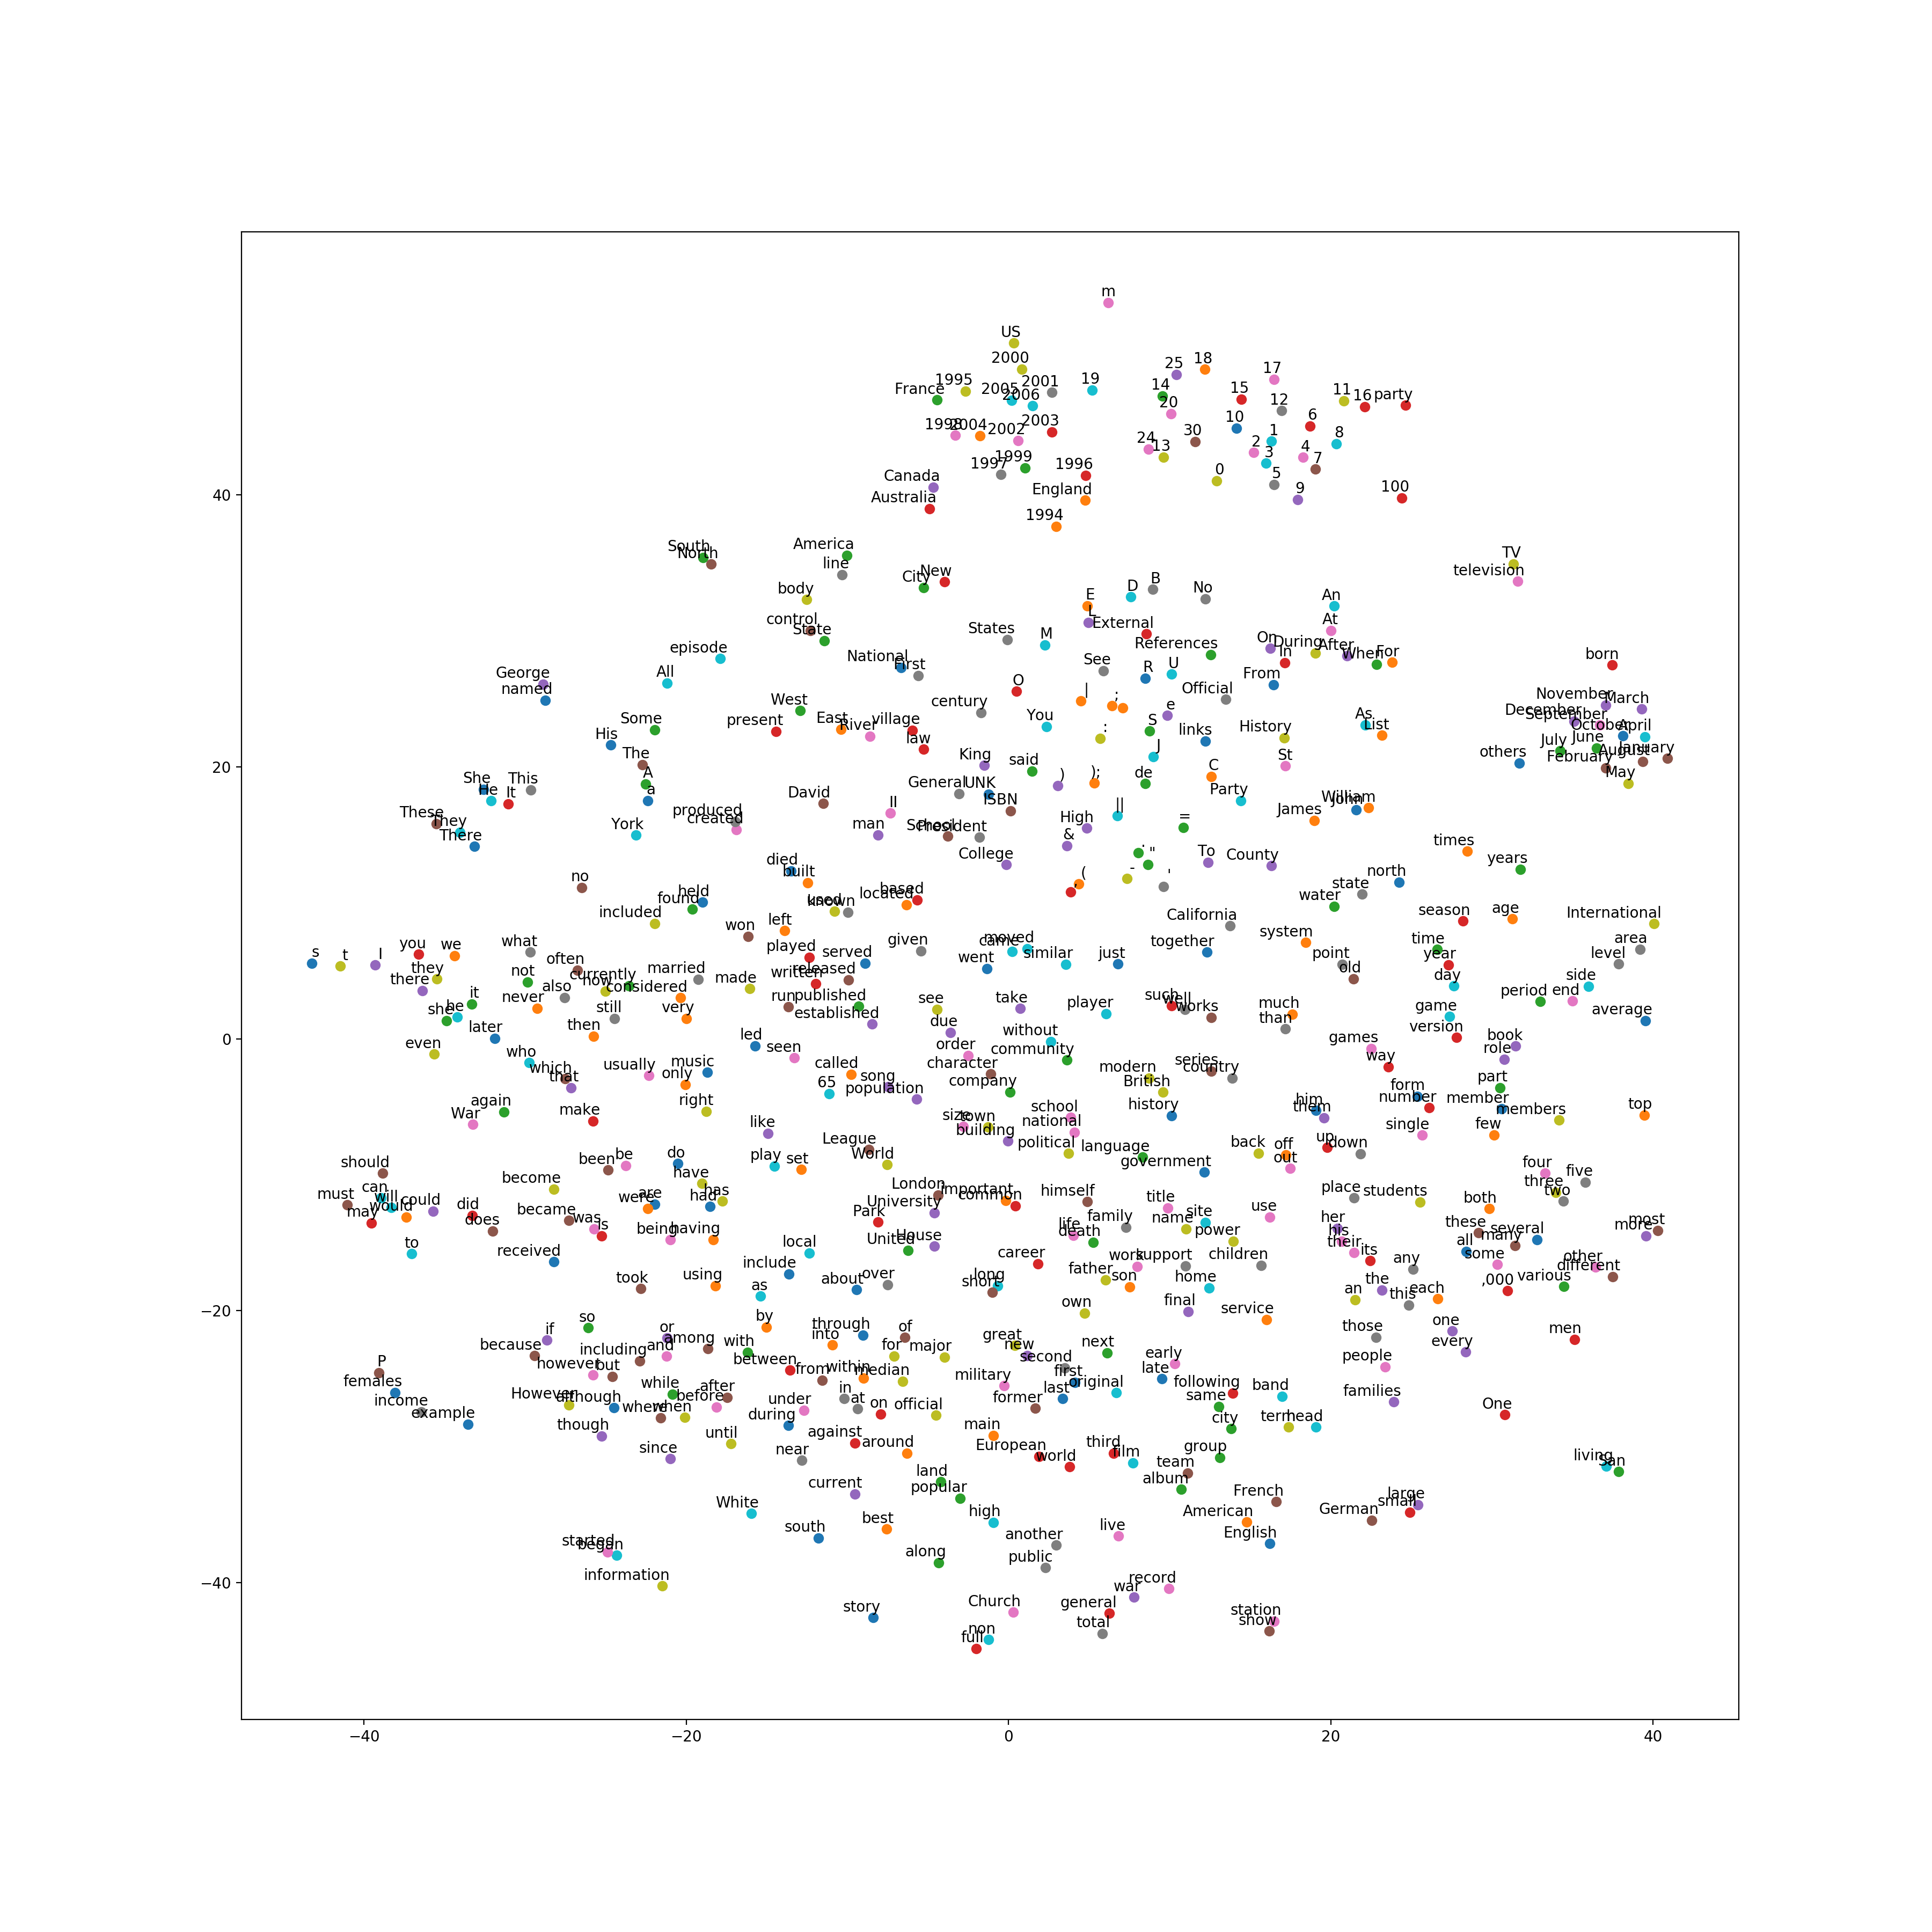

In [47]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points', ha='right', va='bottom')
        
try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
        perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reversed_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(),
                                                        'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)


# Using TSNE to Plot a Subset of Similar Words from Word2Vec

In [48]:
##Reference: https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
# uncomment if gensim is installed
#!pip install gensim
import gensim
# Need the interactive Tools for Matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

In [50]:
# load pre-trained word2vec embeddings
# The embeddings can be downloaded from command prompt:
#wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [66]:
# Test the loaded word2vec model in gensim
# We will need the raw vector for a word
print(cowboy)

# We will also need to get the words closest to a word
model.similar_by_word('cowboy')

[ 0.06255706  0.08517078 -0.04957715 -0.1612131   0.06142722 -0.04231077
  0.1235412  -0.02238435 -0.05813296 -0.07396732  0.12158163  0.07259157
  0.0134893   0.00196428 -0.01347775 -0.05580667 -0.04935372  0.08545774
 -0.07562307  0.10141163  0.04892213 -0.12098096  0.08692326  0.05205343
 -0.11746923  0.05552599 -0.07179915 -0.14437935 -0.03988288  0.06950844
  0.05390302  0.15235808 -0.06247713 -0.02194735 -0.07503019  0.03245085
  0.10651678 -0.05806794 -0.08291401  0.12337292  0.02731927  0.16767068
 -0.0267749  -0.01215926  0.00377058  0.01865445 -0.0947925   0.00513824
  0.00721562  0.0611119  -0.07029942  0.00480304 -0.03629228  0.0640755
 -0.1171065   0.11209169  0.11298306 -0.13735199  0.09312123 -0.04003302
  0.01087978 -0.17495947  0.15603073 -0.13202628  0.09556747 -0.00987941
  0.03674791  0.06249955 -0.17467579  0.19214082 -0.02180416 -0.09846206
 -0.07387269  0.07383138  0.11584412  0.11385201  0.13904797  0.01971654
  0.0307163   0.02223156  0.1446186  -0.07854966 -0.

AttributeError: 'LSTMModel' object has no attribute 'similar_by_word'

In [56]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [57]:
display_closestwords_tsnescatterplot(model, 'cowboy')

NameError: name 'model' is not defined